In [1]:
from IPython.display import Image

# Motivation and Overview of Data:

## Project Purpose:

There is alot of unknown flexability when it comes to recipes.  When you open up a recipe in a book, it is hard to know what leaneancy you have.

We want to compare recipies of different types to find trends in their nutritional value.  We hope that by creating a 

## Questions to Answer:


## Background knowledge/resources: 
Talk about what has been done, and what this will cover that is different.

this is a secret edit

## Data overview:
Talk about what the data looks like before we talk about how we got it (don't walk them through the cleaning process; walk them through what they will see, then talk about how we got it/cleaned it)

# Data Collection and Cleaning:

## Collection Procedure:
talk about how data is used at each step:

The recipe website divided its recipies into categories. Some examples of these are: Chili, Lamb, Potatoes, and even Christmas recipes!
The code to scrape this website divides into 4 functions.

- first one gets the links on the main site
- Then we separate them into categories
- We then collect the recipes
- And we parse through them


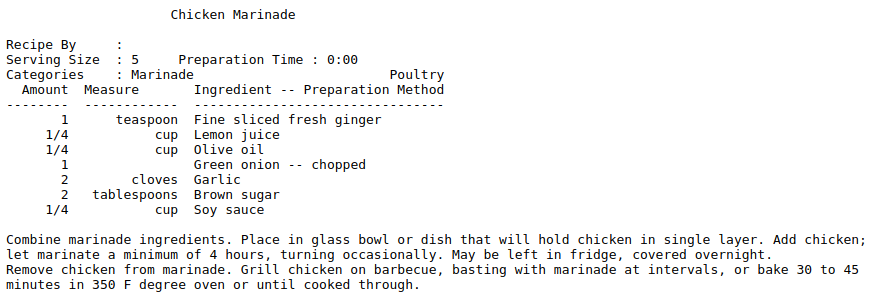

In [5]:
Image("example_recipe.png")

Now that we have the individual ingredients we can start collecting nutritional data

The scaper we build for this task searches each ingredient on nutritionvalue.org and takes the first available 3 links. 
Ex: Oats
![title](nutrition_value_query.png)

In [ ]:
## CODE: Scraper 1
def nutrition_website(ingredients):
    """Use Selenium to enter the given search query into the search bar of
    nutrion website and gets links to scrape data

    Returns:
        (dictonary): urls .
    """
    #initialize variables and chrome
    ingredients_dictionary = {}
    browser = webdriver.Chrome()
    browser.get("https://www.nutritionvalue.org/")
    num_links = 3
    try:
        for i in ingredients:
            try:
                #navigate
                search_bar = browser.find_element_by_name('food_query')
                search_bar.clear()
                search_bar.send_keys(Keys.CONTROL + "a")
                search_bar.send_keys(Keys.DELETE)
                search_bar.send_keys(i)

                search_bar.send_keys(Keys.RETURN)
                
                words = i.split()
                x = ""
                for n,w in enumerate(words):
                    if n == 0:
                        x += ".*(?<!food_query=)"+w+".*|"
                    else:
                        x += ".*(?<!\+)"+w+".*|"
                x = x[:-1]
                find = re.compile(x,re.IGNORECASE)
            
                
                # wait for page to load
                time.sleep(2)
                currentURL = browser.current_url
                if "food_query" in currentURL:
                    
                    links = browser.find_elements_by_tag_name('a')
                    links = [link.get_attribute("href") for link in links if isinstance(link.get_attribute("href"),str)]
                    urls = [link for link in links if len(find.findall(link)) > 0]
                    if len(urls) >num_links:
                        ingredients_dictionary[i] = urls[:num_links]
                    elif len(urls) == 0:
                        ingredients_dictionary[i] = None
                    else:
                        ingredients_dictionary[i] = urls
                else:
                    ingredients_dictionary[i] = [currentURL]
                

            except NoSuchElementException:
                print("could not find the search bar!")
                print(i)
                return ingredients_dictionary
    # close window
    finally:
        browser.close()
    # list with all the links
    return ingredients_dictionary


These links are collected in a dictionary with the ingredient as its respective value.

Then we are ready to get the nutritional value!

Continuing with our oats example, these are a few of the tables from which we got our nutrition data

![title](nutrition_values_oats.png)

In [ ]:
# code for scraper
def nutrition_value(dictionary,set_of_links = set()):
    """Takes in a dictionary with ingredients as keys
    look through the websites and scrape the nutritional value"""
    error_items =[]
    df_d = dict()
    browser = webdriver.Chrome()
    try:
        for k,v in zip(dictionary.keys(),dictionary.values()):
            if v is None:
                df_d[k] = {}
            else:    
                for l in v:
                    try:
                        if l is None:
                            print(f"No Website for: {k}")
                            print()
                        elif l in set_of_links:
                            print(f"Duplicates for {k}")
                        else:
                            browser.get(l)
                            time.sleep(5)
                            # name of ingredient
                            name = browser.find_elements_by_tag_name('h1')[0]
                            name = name.text

                            #setting up nutritional values
                            nut = dict()
                            c = "tbody"
                            tables = browser.find_elements_by_tag_name(c)
                            #### For essentials [4]
                            ser_cal = tables[4].text.split('\n')
                            # Serving Size
                            nut[ser_cal[1][:12]] = ser_cal[1][13:]
                            #Calories
                            nut[ser_cal[3][:8]] = ser_cal[3][9:]

                            #### For all others [7-13]
                            n_v = re.compile('\s*(.*)\s([0-9]+\.[0-9]+\s\w+)')
                            for i in range(7,14):
                                nutrient_value = [n_v.findall(t) for t in tables[i].text.split('\n') if len(t) >0]
                                for t in nutrient_value:
                                    if len(t)>0:
                                        nut[t[0][0]] = t[0][1]

                            df_d[name] = nut
                            set_of_links.add(l)
                        
                    except IndexError as e:
                        error_items.append(k)
                        print(f"ingredient:{k}, error: {e}, link: {l}")
                        print()
                    except:
                        error_items.append(k)
                        print(f"ingredient:{k}, error: IDK, link: {l}")
                        print()
            
    finally:
        browser.close()
    # list with all the links
    
    
    df = pd.DataFrame.from_dict(df_d,'index')
    return df, error_items, set_of_links

    

Our collection was very effective with only two hickups on the columns  of our data set (the number "18" and "adjusted Protein) which we handled by dropping since only one of all the ingredients had these values. 

The rest of the data was cleaned by making all values floats and converting values to grams (g).

In [ ]:
# floats for calories
df = ds
df["Calories"] = df['Calories'].astype('float')/100
df = df.drop(columns = ["18","Adjusted Protein"])
# changing the entries to floats and keeping track of units
clean_columns = list(df.columns)
other_units = []
g_units = []


for j,c in enumerate(clean_columns):
    if c ==  "Calories":
        
        pass
    else:    
        # float values
        n = re.compile(r"(^\d*\.?\d*)\s(\w+)")
        
        ### changing Na for 0's, to go back change 0 to np.nan
        num = np.array([float(n.findall(i)[0][0]) if isinstance(i,str) else 0 for i in df[c].values])
        mes = np.array([n.findall(i)[0][1] if isinstance(i,str) else 'g' for i in df[c].values])

        # messurements
        mask_mg = (mes == 'mg')/10
        mask_mcg = (mes == "mcg")/10000
        mask_g = (mes == "g")*.01
        mask = mask_mg + mask_mcg +mask_g
        
        mask += (mask==0)*-1

        if sum(mask < 0) >1 :
            df[c] = num/100

        else:
            df[c] = num*mask
            
        g_units.append(c)
# append new features
VitaminA_conv = 0.6/1000000
VitaminD_conv = 0.025/1000000

df["Vitamin A"] *= 0.6/1000000
df["Vitamin D"] *= 0.025/1000000
df.rename(columns = {c:c for c in g_units if c!= "Calories"},inplace = True)

df.head()


## Cleaning Procedure:
explain reason for dropping columns
explain what (g) means if it's in the variable names; explain how we handled missing, badly formatted data.  What did we drop and what did we adjust? change more stuff


Code Quality and Robustness:

Data Visualization and Analysis:

# Hel